# Image Mosaicking with Homography

This notebook demonstrates image mosaicking using homography transformations. We'll:
1. Compute homography matrices from point correspondences
2. Warp images to align them
3. Create seamless mosaics using different blending techniques


## 1. Setup and Imports

Import necessary libraries for image processing, homography computation, and visualization.


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from scipy.spatial.distance import cdist

## 2. Homography Computation

The homography matrix H maps points from one image plane to another. We use the Direct Linear Transform (DLT) algorithm with SVD to compute H from point correspondences.


In [3]:
def compute_homography(image1points, image2points):
    """
    Computes the homography matrix H that maps points from image1 to image2.
    
    Parameters:
    -----------
    image1points : numpy array of shape (N, 2)
        Points from the first image
    image2points : numpy array of shape (N, 2)
        Corresponding points from the second image
    
    Returns:
    --------
    H : numpy array of shape (3, 3)
        Homography matrix
    """
    # Check that we have at least 4 point correspondences
    n_points = len(image1points)
    if n_points < 4:
        raise ValueError("At least 4 point correspondences are required")
    
    # Build the A matrix for the DLT (Direct Linear Transform) algorithm
    # Each point correspondence gives us 2 equations
    A = np.zeros((2 * n_points, 9))
    
    for i in range(n_points):
        x1, y1 = image1points[i]
        x2, y2 = image2points[i]
        
        # First equation: -x2 = -h11*x1 - h12*y1 - h13 + h31*x1*x2 + h32*y1*x2 + h33*x2
        # Rearranged: h11*x1 + h12*y1 + h13 - h31*x1*x2 - h32*y1*x2 - h33*x2 = 0
        A[2*i, 0] = x1
        A[2*i, 1] = y1
        A[2*i, 2] = 1
        A[2*i, 3] = 0
        A[2*i, 4] = 0
        A[2*i, 5] = 0
        A[2*i, 6] = -x1 * x2
        A[2*i, 7] = -y1 * x2
        A[2*i, 8] = -x2
        
        # Second equation: -y2 = -h21*x1 - h22*y1 - h23 + h31*x1*y2 + h32*y1*y2 + h33*y2
        # Rearranged: h21*x1 + h22*y1 + h23 - h31*x1*y2 - h32*y1*y2 - h33*y2 = 0
        A[2*i+1, 0] = 0
        A[2*i+1, 1] = 0
        A[2*i+1, 2] = 0
        A[2*i+1, 3] = x1
        A[2*i+1, 4] = y1
        A[2*i+1, 5] = 1
        A[2*i+1, 6] = -x1 * y2
        A[2*i+1, 7] = -y1 * y2
        A[2*i+1, 8] = -y2
    
    # Solve using SVD (Total Least Squares approach)
    # We want to find h such that A*h = 0, i.e., h is in the null space of A
    _, _, Vt = np.linalg.svd(A)
    
    # The solution is the last column of V (last row of Vt)
    # This corresponds to the eigenvector with the smallest eigenvalue
    h = Vt[-1, :]
    
    # Reshape to 3x3 matrix
    H = h.reshape(3, 3)
    
    # Normalize the homography matrix (so H[2,2] = 1)
    H = H / H[2, 2]
    
    return H


## 3. Load and Display Images

Load the two images that we want to create a mosaic from.


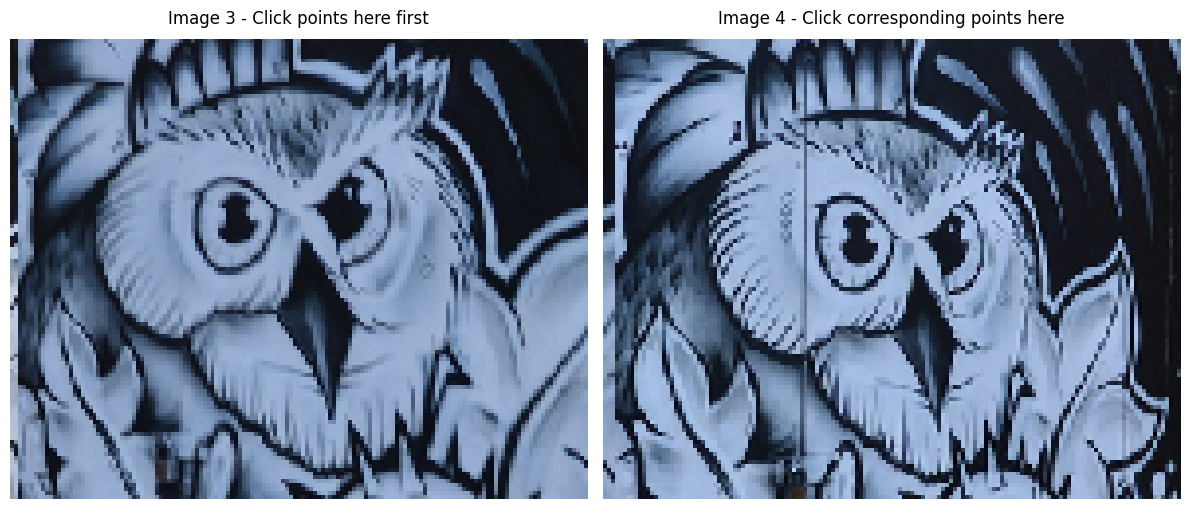

In [4]:
# Load the two images
img1 = plt.imread('image_3.png')
img2 = plt.imread('image_4.png')

# Display both images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].set_title('Image 3 - Click points here first')
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].set_title('Image 4 - Click corresponding points here')
axes[1].axis('off')
plt.tight_layout()
plt.show()


## 4. Load Point Correspondences

Load the correspondence points that were previously selected using the `click_points.py` script. These points define matching features between the two images.


Loading correspondence points from correspondence_points.npz...

Loaded 16 point correspondences
Image 1 points (Image 3):
[[ 66.66883117  45.57142857]
 [ 77.67532468  44.4025974 ]
 [ 86.14935065  35.92857143]
 [ 89.55844156  32.90909091]
 [ 84.59090909  59.5       ]
 [ 83.22727273  52.38961039]
 [ 74.65584416  52.29220779]
 [ 86.92857143  72.06493506]
 [ 81.66883117  98.65584416]
 [ 67.83766234  71.96753247]
 [ 44.46103896  78.59090909]
 [ 31.50649351  29.5974026 ]
 [ 71.34415584  12.84415584]
 [ 89.16883117  17.90909091]
 [105.04545455  25.40909091]
 [119.46103896  61.05844156]]

Image 2 points (Image 4):
[[ 73.38961039  52.29220779]
 [ 81.86363636  52.68181818]
 [ 88.0974026   47.03246753]
 [ 91.01948052  43.23376623]
 [ 87.70779221  66.22077922]
 [ 85.95454545  61.15584416]
 [ 79.81818182  59.98701299]
 [ 89.65584416  79.17532468]
 [ 85.37012987 100.21428571]
 [ 73.68181818  76.44805195]
 [ 52.05844156  82.0974026 ]
 [ 37.74025974  28.91558442]
 [ 76.6038961   21.41558442]
 [ 91.50

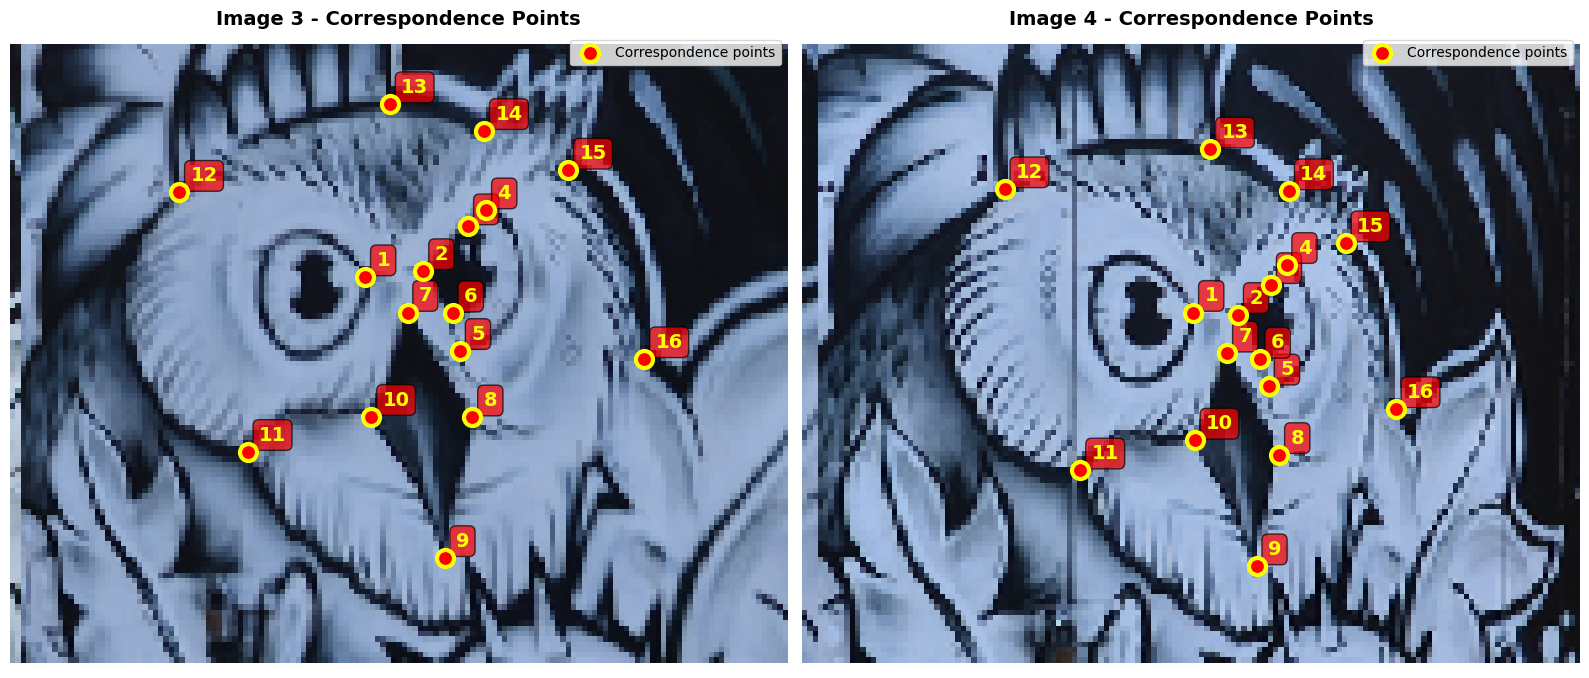


✓ Displayed 16 correspondence points on both images
   (Points with the same number correspond to each other)


In [9]:
# Load point correspondences from the .npz file
# (Points were collected using the click_points.py script)
print("Loading correspondence points from correspondence_points.npz...")

# Load the saved points
data = np.load('correspondence_points.npz')
image1points = data['image1points']
image2points = data['image2points']

print(f"\nLoaded {len(image1points)} point correspondences")
print("Image 1 points (Image 3):")
print(image1points)
print("\nImage 2 points (Image 4):")
print(image2points)

# Visualize the correspondence points on both images
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Display Image 3 with points
axes[0].imshow(img1)
axes[0].scatter(image1points[:, 0], image1points[:, 1], c='red', s=150, marker='o', 
                edgecolors='yellow', linewidths=3, label='Correspondence points', zorder=5)
# Add point numbers
for i, point in enumerate(image1points):
    axes[0].annotate(f'{i+1}', (point[0], point[1]), fontsize=14, color='yellow', 
                     weight='bold', xytext=(8, 8), textcoords='offset points',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))
axes[0].set_title('Image 3 - Correspondence Points', fontsize=14, fontweight='bold')
axes[0].axis('off')
axes[0].legend(loc='upper right', fontsize=10)

# Display Image 4 with points
axes[1].imshow(img2)
axes[1].scatter(image2points[:, 0], image2points[:, 1], c='red', s=150, marker='o', 
                edgecolors='yellow', linewidths=3, label='Correspondence points', zorder=5)
# Add point numbers
for i, point in enumerate(image2points):
    axes[1].annotate(f'{i+1}', (point[0], point[1]), fontsize=14, color='yellow', 
                     weight='bold', xytext=(8, 8), textcoords='offset points',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))
axes[1].set_title('Image 4 - Correspondence Points', fontsize=14, fontweight='bold')
axes[1].axis('off')
axes[1].legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n✓ Displayed {len(image1points)} correspondence points on both images")
print("   (Points with the same number correspond to each other)")


## 5. Compute Homography Matrix

Compute the homography matrix H that transforms points from Image 3 to Image 4.


In [10]:
# Compute the homography matrix
H = compute_homography(image1points, image2points)

print("Homography Matrix H:")
print(H)
print(f"\nDeterminant of H: {np.linalg.det(H):.6f}")


Homography Matrix H:
[[ 1.62840125e+00  1.28912381e-01 -1.10167151e+01]
 [ 4.76408279e-01  1.45481758e+00 -2.38743775e+01]
 [ 5.26351762e-03  1.52546345e-03  1.00000000e+00]]

Determinant of H: 2.427072


## 6. Verify Homography Accuracy

Apply the computed homography to the original points and compare with the target points to measure reprojection error.


In [11]:
# Verify the homography by transforming image1points and comparing with image2points
def apply_homography(points, H):
    """
    Applies homography H to a set of points.
    
    Parameters:
    -----------
    points : numpy array of shape (N, 2)
        Points to transform
    H : numpy array of shape (3, 3)
        Homography matrix
    
    Returns:
    --------
    transformed_points : numpy array of shape (N, 2)
        Transformed points
    """
    # Convert to homogeneous coordinates
    ones = np.ones((len(points), 1))
    points_homogeneous = np.hstack([points, ones])
    
    # Apply homography
    transformed_homogeneous = (H @ points_homogeneous.T).T
    
    # Convert back to Cartesian coordinates
    transformed_points = transformed_homogeneous[:, :2] / transformed_homogeneous[:, 2:3]
    
    return transformed_points


Reprojection Errors:
Point 1: 0.58 pixels
Point 2: 0.22 pixels
Point 3: 1.21 pixels
Point 4: 0.69 pixels
Point 5: 0.85 pixels
Point 6: 0.76 pixels
Point 7: 0.43 pixels
Point 8: 1.19 pixels
Point 9: 0.18 pixels
Point 10: 0.82 pixels
Point 11: 0.84 pixels
Point 12: 1.48 pixels
Point 13: 0.77 pixels
Point 14: 0.62 pixels
Point 15: 0.65 pixels
Point 16: 0.59 pixels

Mean error: 0.74 pixels
Max error: 1.48 pixels


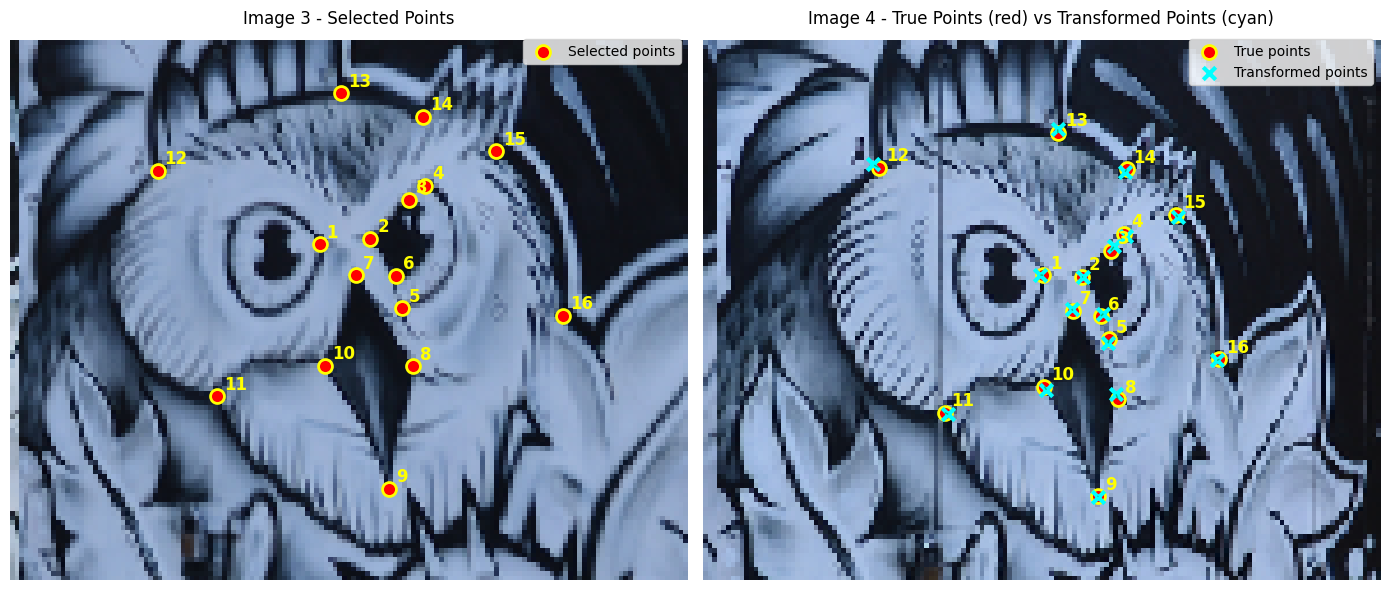

In [12]:

# Transform image1points using the computed homography
transformed_points = apply_homography(image1points, H)

# Compute reprojection error
errors = np.linalg.norm(image2points - transformed_points, axis=1)
mean_error = np.mean(errors)
max_error = np.max(errors)

print("Reprojection Errors:")
for i, error in enumerate(errors):
    print(f"Point {i+1}: {error:.2f} pixels")
print(f"\nMean error: {mean_error:.2f} pixels")
print(f"Max error: {max_error:.2f} pixels")

# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot image 1 with original points
axes[0].imshow(img1)
axes[0].scatter(image1points[:, 0], image1points[:, 1], c='red', s=100, marker='o', 
                edgecolors='yellow', linewidths=2, label='Selected points')
for i, point in enumerate(image1points):
    axes[0].annotate(f'{i+1}', (point[0], point[1]), fontsize=12, color='yellow', 
                     weight='bold', xytext=(5, 5), textcoords='offset points')
axes[0].set_title('Image 3 - Selected Points')
axes[0].axis('off')
axes[0].legend()

# Plot image 2 with original and transformed points
axes[1].imshow(img2)
axes[1].scatter(image2points[:, 0], image2points[:, 1], c='red', s=100, marker='o', 
                edgecolors='yellow', linewidths=2, label='True points')
axes[1].scatter(transformed_points[:, 0], transformed_points[:, 1], c='cyan', s=80, 
                marker='x', linewidths=3, label='Transformed points')
for i, (point1, point2) in enumerate(zip(image2points, transformed_points)):
    axes[1].annotate(f'{i+1}', (point1[0], point1[1]), fontsize=12, color='yellow', 
                     weight='bold', xytext=(5, 5), textcoords='offset points')
    # Draw line connecting true and transformed points
    axes[1].plot([point1[0], point2[0]], [point1[1], point2[1]], 'g--', alpha=0.5, linewidth=1)
axes[1].set_title('Image 4 - True Points (red) vs Transformed Points (cyan)')
axes[1].axis('off')
axes[1].legend()

plt.tight_layout()
plt.show()


## 7. Image Warping

Warp Image 3 using the computed homography to align it with Image 4.

In [15]:
# Optional: Warp image1 using the homography to align with image2

def warp_image(image, H, output_shape=None):
    """
    Warps an image using a homography matrix.
    
    Parameters:
    -----------
    image : numpy array
        Input image to warp
    H : numpy array of shape (3, 3)
        Homography matrix
    output_shape : tuple (height, width), optional
        Output image shape. If None, uses input image shape.
    
    Returns:
    --------
    warped_image : numpy array
        Warped image
    """
    if output_shape is None:
        h, w = image.shape[:2]
    else:
        h, w = output_shape
    
    # Create coordinate grid
    y_coords, x_coords = np.mgrid[0:h, 0:w]
    
    # Flatten coordinates
    coords = np.stack([x_coords.flatten(), y_coords.flatten(), np.ones(h*w)])
    
    # Apply inverse homography to find source coordinates
    H_inv = np.linalg.inv(H)
    source_coords = (H_inv @ coords).T
    source_coords = source_coords[:, :2] / source_coords[:, 2:3]
    
    # Reshape to image coordinates
    source_x = source_coords[:, 0].reshape(h, w)
    source_y = source_coords[:, 1].reshape(h, w)
    
    # Interpolate pixel values using OpenCV
    if len(image.shape) == 3:
        warped = cv2.remap(image, 
                           source_x.astype(np.float32), 
                           source_y.astype(np.float32),
                           cv2.INTER_LINEAR,
                           borderMode=cv2.BORDER_CONSTANT)
    else:
        warped = cv2.remap(image, 
                           source_x.astype(np.float32), 
                           source_y.astype(np.float32),
                           cv2.INTER_LINEAR,
                           borderMode=cv2.BORDER_CONSTANT)
    
    return warped


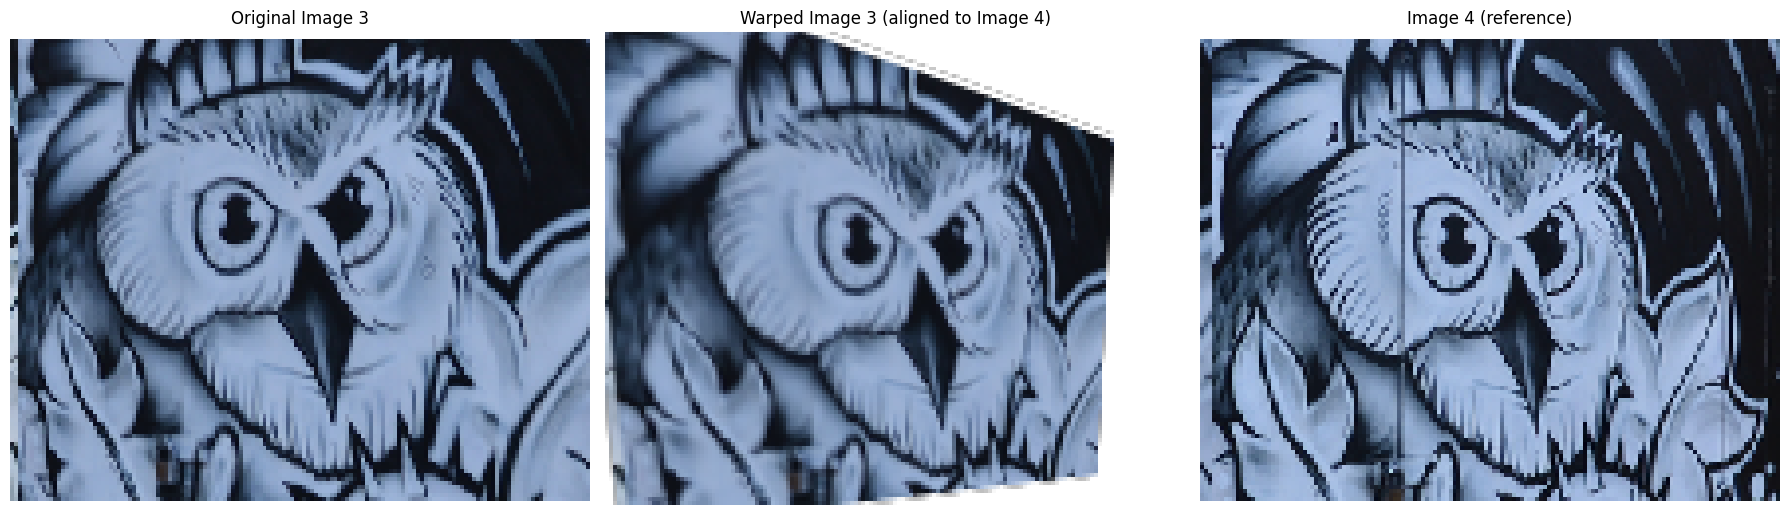

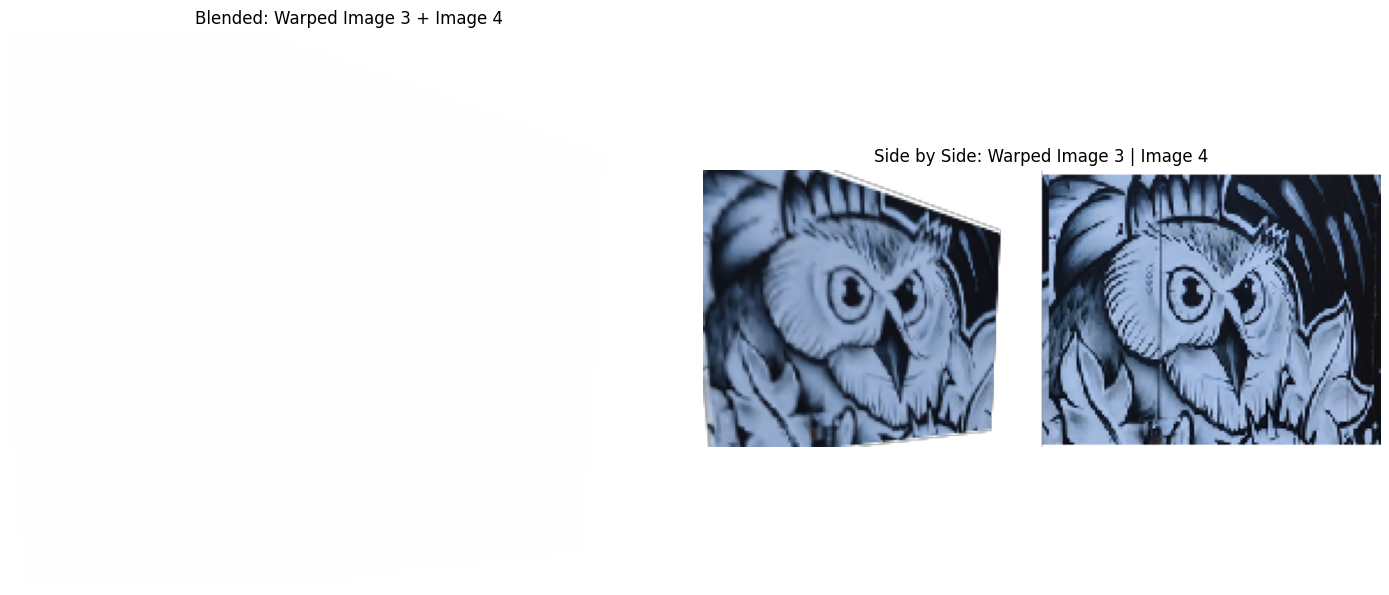

In [16]:

# Warp image1 to align with image2
img1_warped = warp_image(img1, H, output_shape=img2.shape[:2])

# Display results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(img1)
axes[0].set_title('Original Image 3')
axes[0].axis('off')

axes[1].imshow(img1_warped)
axes[1].set_title('Warped Image 3 (aligned to Image 4)')
axes[1].axis('off')

axes[2].imshow(img2)
axes[2].set_title('Image 4 (reference)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Show overlay comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
blend = (img1_warped.astype(float) + img2.astype(float)) / 2
axes[0].imshow(blend.astype(np.uint8))
axes[0].set_title('Blended: Warped Image 3 + Image 4')
axes[0].axis('off')

# Create side-by-side comparison
comparison = np.hstack([img1_warped, img2])
axes[1].imshow(comparison)
axes[1].set_title('Side by Side: Warped Image 3 | Image 4')
axes[1].axis('off')
plt.tight_layout()
plt.show()


In [38]:
def compute_mosaic_bbox(images, homographies):
    """
    Computes the bounding box that contains all warped images.
    
    Parameters:
    -----------
    images : list of numpy arrays
        List of input images
    homographies : list of numpy arrays
        List of homography matrices (one per image, or None for unwarped image)
    
    Returns:
    --------
    bbox : tuple (min_x, min_y, max_x, max_y)
        Bounding box coordinates
    offset : tuple (offset_x, offset_y)
        Offset to apply to make coordinates non-negative
    """
    all_corners = []
    
    for img, H in zip(images, homographies):
        h, w = img.shape[:2]
        # Get image corners
        corners = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)
        
        if H is not None:
            # Transform corners using homography
            corners_homogeneous = np.hstack([corners, np.ones((4, 1))])
            transformed = (H @ corners_homogeneous.T).T
            transformed = transformed[:, :2] / transformed[:, 2:3]
            all_corners.append(transformed)
        else:
            all_corners.append(corners)
    
    all_corners = np.vstack(all_corners)
    
    min_x, min_y = np.floor(all_corners.min(axis=0)).astype(int)
    max_x, max_y = np.ceil(all_corners.max(axis=0)).astype(int)
    
    offset_x = -min_x if min_x < 0 else 0
    offset_y = -min_y if min_y < 0 else 0
    
    return (min_x, min_y, max_x, max_y), (offset_x, offset_y)


In [39]:
def create_alpha_mask(shape, feather_width=50):
    """
    Creates an alpha mask with feathering at the edges.
    
    Parameters:
    -----------
    shape : tuple (height, width)
        Shape of the mask
    feather_width : int
        Width of the feathering region in pixels
    
    Returns:
    --------
    alpha : numpy array
        Alpha mask with values between 0 and 1
    """
    h, w = shape
    alpha = np.ones((h, w), dtype=np.float32)
    
    # Create distance maps from edges
    y_coords, x_coords = np.mgrid[0:h, 0:w]
    
    # Distance from each edge
    dist_top = y_coords
    dist_bottom = h - y_coords
    dist_left = x_coords
    dist_right = w - x_coords
    
    # Find minimum distance to any edge
    dist_to_edge = np.minimum(np.minimum(dist_top, dist_bottom),
                              np.minimum(dist_left, dist_right))
    
    # Apply feathering: linear falloff in the feather region
    mask = np.clip(dist_to_edge / feather_width, 0, 1)
    
    return mask


## 8. Mosaic Creation

Create a seamless mosaic by blending the warped images together. We'll use weighted averaging with feathering to create smooth transitions.


In [45]:
def create_mosaic(images, homographies, reference_idx=0, feather_width=50):
    """
    Creates a mosaic by blending multiple images with weighted averaging.
    
    Parameters:
    -----------
    images : list of numpy arrays
        List of input images (can be RGB or RGBA, values in [0, 1] or [0, 255])
    homographies : list of numpy arrays or None
        List of homography matrices for backward mapping (inverse transforms).
        None means the image is not warped.
        If reference_idx is set, that image's homography should be None.
    reference_idx : int
        Index of the reference image (unwarped)
    feather_width : int
        Width of feathering region for blending
    
    Returns:
    --------
    mosaic : numpy array
        Final blended mosaic (uint8, values in [0, 255])
    """
    # Normalize images to [0, 255] range and handle RGBA
    normalized_images = []
    for i, img in enumerate(images):
        # Handle RGBA: convert to RGB by discarding alpha or using alpha blending
        if img.shape[2] == 4:
            # Use RGB channels only (discard alpha)
            img = img[:, :, :3]
        
        # Debug: Check original image range
        img_max = img.max()
        img_min = img.min()
        print(f"DEBUG: Image {i} before normalization: dtype={img.dtype}, min={img_min:.3f}, max={img_max:.3f}, mean={img.mean():.3f}")
        
        # Normalize to [0, 255] range
        # Check if values are in [0, 1] range (allowing for small floating point errors)
        if img_max <= 1.0 + 1e-6:
            # Values are in [0, 1] range, scale to [0, 255]
            img = (img * 255.0).astype(np.float32)
            print(f"DEBUG: Image {i} normalized (was [0,1]): min={img.min():.3f}, max={img.max():.3f}, mean={img.mean():.3f}")
        else:
            # Values are already in [0, 255] range (or higher), just ensure float32
            img = img.astype(np.float32)
            print(f"DEBUG: Image {i} kept as-is (was [0,255]): min={img.min():.3f}, max={img.max():.3f}, mean={img.mean():.3f}")
        
        # Ensure values are in [0, 255] range
        img = np.clip(img, 0, 255)
        
        normalized_images.append(img)
    
    images = normalized_images
    # For bbox computation, we need forward transformations (where corners end up)
    # So we invert the homographies if they're provided
    forward_homographies = []
    for H in homographies:
        if H is not None:
            forward_homographies.append(np.linalg.inv(H))
        else:
            forward_homographies.append(None)
    
    # Compute bounding box for the mosaic using forward transformations
    bbox, offset = compute_mosaic_bbox(images, forward_homographies)
    min_x, min_y, max_x, max_y = bbox
    offset_x, offset_y = offset
    
    # Debug output
    print(f"DEBUG: bbox = ({min_x}, {min_y}, {max_x}, {max_y})")
    print(f"DEBUG: offset = ({offset_x}, {offset_y})")
    
    # Calculate output dimensions
    # The bbox gives us the range, and offset tells us how much to shift
    # Output size = range + 1 (to include both endpoints)
    out_w = int(max_x - min_x + 1)
    out_h = int(max_y - min_y + 1)
    print(f"DEBUG: output dimensions = {out_w} x {out_h}")
    
    # Initialize output arrays (images are now guaranteed to be RGB, 3 channels)
    mosaic = np.zeros((out_h, out_w, 3), dtype=np.float32)
    weight_sum = np.zeros((out_h, out_w), dtype=np.float32)
    
    # Process each image
    for i, (img, H) in enumerate(zip(images, homographies)):
        h, w = img.shape[:2]
        
        # Create coordinate grid for output
        y_coords, x_coords = np.mgrid[0:out_h, 0:out_w]
        
        if H is not None:
            # For warped images: adjust coordinates to get coordinates in output/reference space
            # Then transform to source image space using inverse homography
            x_coords_adj = x_coords - offset_x
            y_coords_adj = y_coords - offset_y
            
            # Transform coordinates using inverse homography (H is already the inverse for backward mapping)
            coords = np.stack([x_coords_adj.flatten(), y_coords_adj.flatten(), np.ones(out_h * out_w)])
            source_coords = (H @ coords).T
            source_coords = source_coords[:, :2] / source_coords[:, 2:3]
            
            source_x = source_coords[:, 0].reshape(out_h, out_w)
            source_y = source_coords[:, 1].reshape(out_h, out_w)
        else:
            # For reference image: it's at (offset_x, offset_y) in the output coordinate system
            # Output coordinate (offset_x, offset_y) corresponds to image coordinate (0, 0)
            # So: image_coord = output_coord - offset
            source_x = x_coords - offset_x
            source_y = y_coords - offset_y
        
        # Create mask for valid pixels (within image bounds)
        valid_mask = (source_x >= 0) & (source_x < w) & (source_y >= 0) & (source_y < h)
        
        # Warp the image (img is now guaranteed to be 3-channel RGB)
        warped = np.zeros((out_h, out_w, 3), dtype=np.float32)
        for c in range(3):
            warped[:, :, c] = cv2.remap(img[:, :, c],
                                        source_x.astype(np.float32),
                                        source_y.astype(np.float32),
                                        cv2.INTER_LINEAR,
                                        borderMode=cv2.BORDER_CONSTANT)
        
        # Create alpha mask with feathering
        alpha = create_alpha_mask((h, w), feather_width)
        
        # Warp the alpha mask
        alpha_warped = cv2.remap(alpha,
                                source_x.astype(np.float32),
                                source_y.astype(np.float32),
                                cv2.INTER_LINEAR,
                                borderMode=cv2.BORDER_CONSTANT)
        
        # Apply valid mask
        alpha_warped = alpha_warped * valid_mask
        
        # Debug: Check valid pixels and warped image values
        num_valid = valid_mask.sum()
        print(f"DEBUG: Image {i}: {num_valid} valid pixels out of {out_h * out_w} total")
        print(f"DEBUG: Image {i}: alpha_warped min={alpha_warped.min():.3f}, max={alpha_warped.max():.3f}, mean={alpha_warped.mean():.3f}")
        print(f"DEBUG: Image {i}: warped min={warped.min():.3f}, max={warped.max():.3f}, mean={warped.mean():.3f}")
        
        # Accumulate weighted image (img is now guaranteed to be 3-channel RGB)
        for c in range(3):
            mosaic[:, :, c] += warped[:, :, c] * alpha_warped
        
        weight_sum += alpha_warped
    
    # Normalize by weight sum (avoid division by zero)
    print(f"DEBUG: weight_sum min={weight_sum.min():.3f}, max={weight_sum.max():.3f}, mean={weight_sum.mean():.3f}")
    print(f"DEBUG: Pixels with zero weight: {(weight_sum == 0).sum()}")
    
    weight_sum = np.maximum(weight_sum, 1e-10)
    for c in range(3):
        mosaic[:, :, c] /= weight_sum
    
    print(f"DEBUG: Mosaic before uint8 conversion: min={mosaic.min():.2f}, max={mosaic.max():.2f}, mean={mosaic.mean():.2f}")
    
    # Convert to uint8 (values should already be in [0, 255] range)
    mosaic = np.clip(mosaic, 0, 255).astype(np.uint8)
    
    return mosaic


Image 1 shape: (120, 147, 4)
Image 2 shape: (120, 147, 4)

H (forward, image1->image2):
[[ 1.62840125e+00  1.28912381e-01 -1.10167151e+01]
 [ 4.76408279e-01  1.45481758e+00 -2.38743775e+01]
 [ 5.26351762e-03  1.52546345e-03  1.00000000e+00]]

H_inv (backward, image2->image1):
[[ 6.14418258e-01 -6.00385997e-02  5.33548671e+00]
 [-2.48064993e-01  6.94824149e-01  1.38556327e+01]
 [-2.85558725e-03 -7.43914618e-04  9.50780310e-01]]

Image 1 corners in image 2 space:
[[-11.01671511 -23.87437755]
 [128.7441467   26.0228191 ]
 [124.60581709 112.80487122]
 [  3.76378805 127.38516286]]
DEBUG: Image 0 before normalization: dtype=float32, min=0.012, max=1.000, mean=0.463
DEBUG: Image 0 normalized (was [0,1]): min=3.000, max=255.000, mean=117.998
DEBUG: Image 1 before normalization: dtype=float32, min=0.000, max=1.000, mean=0.448
DEBUG: Image 1 normalized (was [0,1]): min=0.000, max=255.000, mean=114.278
DEBUG: bbox = (-12, -24, 147, 128)
DEBUG: offset = (12, 24)
DEBUG: output dimensions = 160 x 15

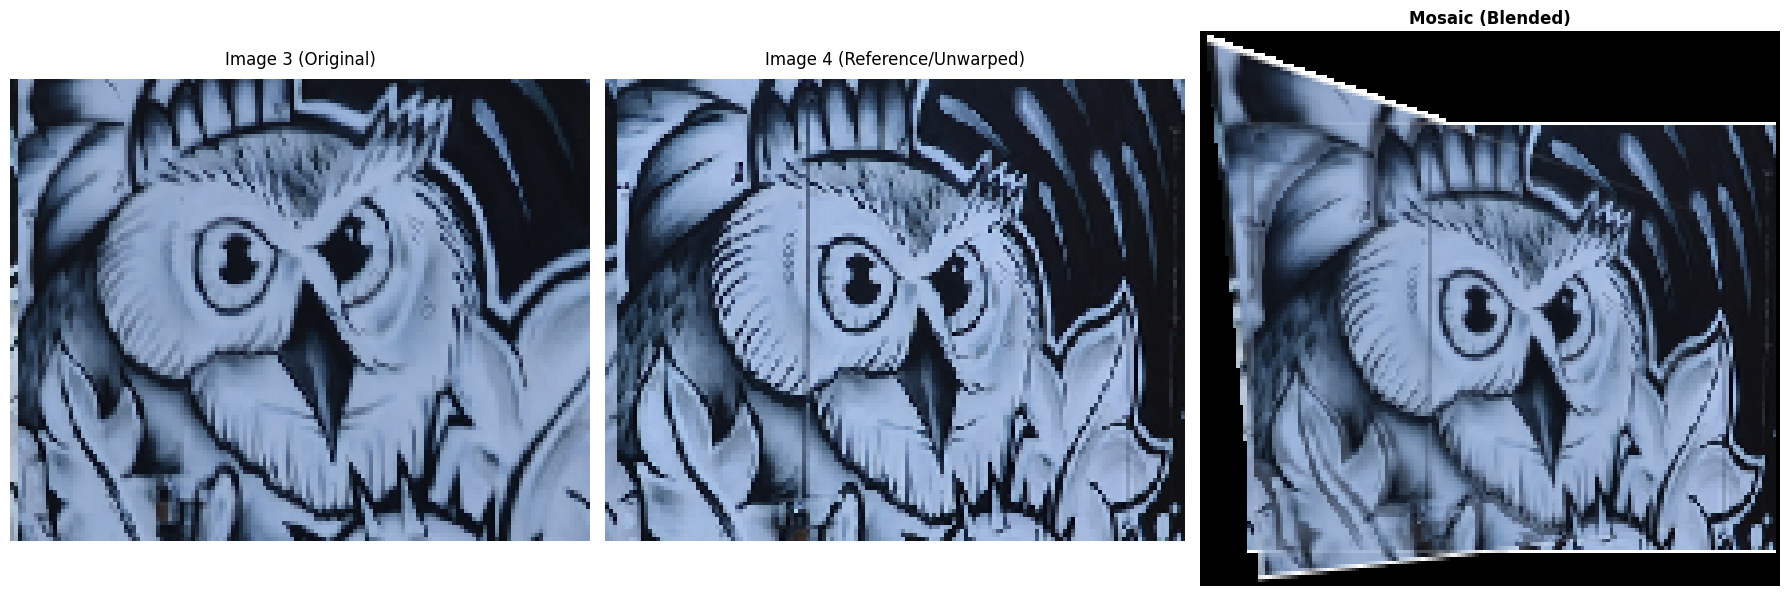


Mosaic dimensions: 160 x 153 pixels
Mosaic min/max values: 0, 255
Mosaic mean value: 85.10


In [46]:
# Create mosaic: Leave image2 unwarped, warp image1 into image2's projection
# We need the inverse homography to warp image1 into image2's space
H_inv = np.linalg.inv(H)

# Debug: Check image shapes and homography
print(f"Image 1 shape: {img1.shape}")
print(f"Image 2 shape: {img2.shape}")
print(f"\nH (forward, image1->image2):")
print(H)
print(f"\nH_inv (backward, image2->image1):")
print(H_inv)

# Test: Transform image1 corners to image2 space using H
h1, w1 = img1.shape[:2]
corners_img1 = np.array([[0, 0], [w1, 0], [w1, h1], [0, h1]], dtype=np.float32)
corners_homogeneous = np.hstack([corners_img1, np.ones((4, 1))])
corners_in_img2_space = (H @ corners_homogeneous.T).T
corners_in_img2_space = corners_in_img2_space[:, :2] / corners_in_img2_space[:, 2:3]
print(f"\nImage 1 corners in image 2 space:")
print(corners_in_img2_space)

# Create the mosaic
# images: [img1, img2]
# homographies: [H_inv (to warp img1), None (img2 is reference/unwarped)]
mosaic = create_mosaic([img1, img2], [H_inv, None], reference_idx=1, feather_width=50)

# Display the result
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(img1)
axes[0].set_title('Image 3 (Original)', fontsize=12)
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title('Image 4 (Reference/Unwarped)', fontsize=12)
axes[1].axis('off')

axes[2].imshow(mosaic)
axes[2].set_title('Mosaic (Blended)', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"\nMosaic dimensions: {mosaic.shape[1]} x {mosaic.shape[0]} pixels")
print(f"Mosaic min/max values: {mosaic.min()}, {mosaic.max()}")
print(f"Mosaic mean value: {mosaic.mean():.2f}")


DEBUG: Image 0 before normalization: dtype=float32, min=0.012, max=1.000, mean=0.463
DEBUG: Image 0 normalized (was [0,1]): min=3.000, max=255.000, mean=117.998
DEBUG: Image 1 before normalization: dtype=float32, min=0.000, max=1.000, mean=0.448
DEBUG: Image 1 normalized (was [0,1]): min=0.000, max=255.000, mean=114.278
DEBUG: bbox = (-12, -24, 147, 128)
DEBUG: offset = (12, 24)
DEBUG: output dimensions = 160 x 153
DEBUG: Image 0: 15414 valid pixels out of 24480 total
DEBUG: Image 0: alpha_warped min=0.000, max=1.000, mean=0.577
DEBUG: Image 0: warped min=0.000, max=255.000, mean=74.663
DEBUG: Image 1: 17640 valid pixels out of 24480 total
DEBUG: Image 1: alpha_warped min=0.000, max=1.000, mean=0.667
DEBUG: Image 1: warped min=0.000, max=255.000, mean=82.348
DEBUG: weight_sum min=0.000, max=2.000, mean=1.245
DEBUG: Pixels with zero weight: 5625
DEBUG: Mosaic before uint8 conversion: min=0.00, max=255.00, mean=85.43
DEBUG: Image 0 before normalization: dtype=float32, min=0.012, max=1.00

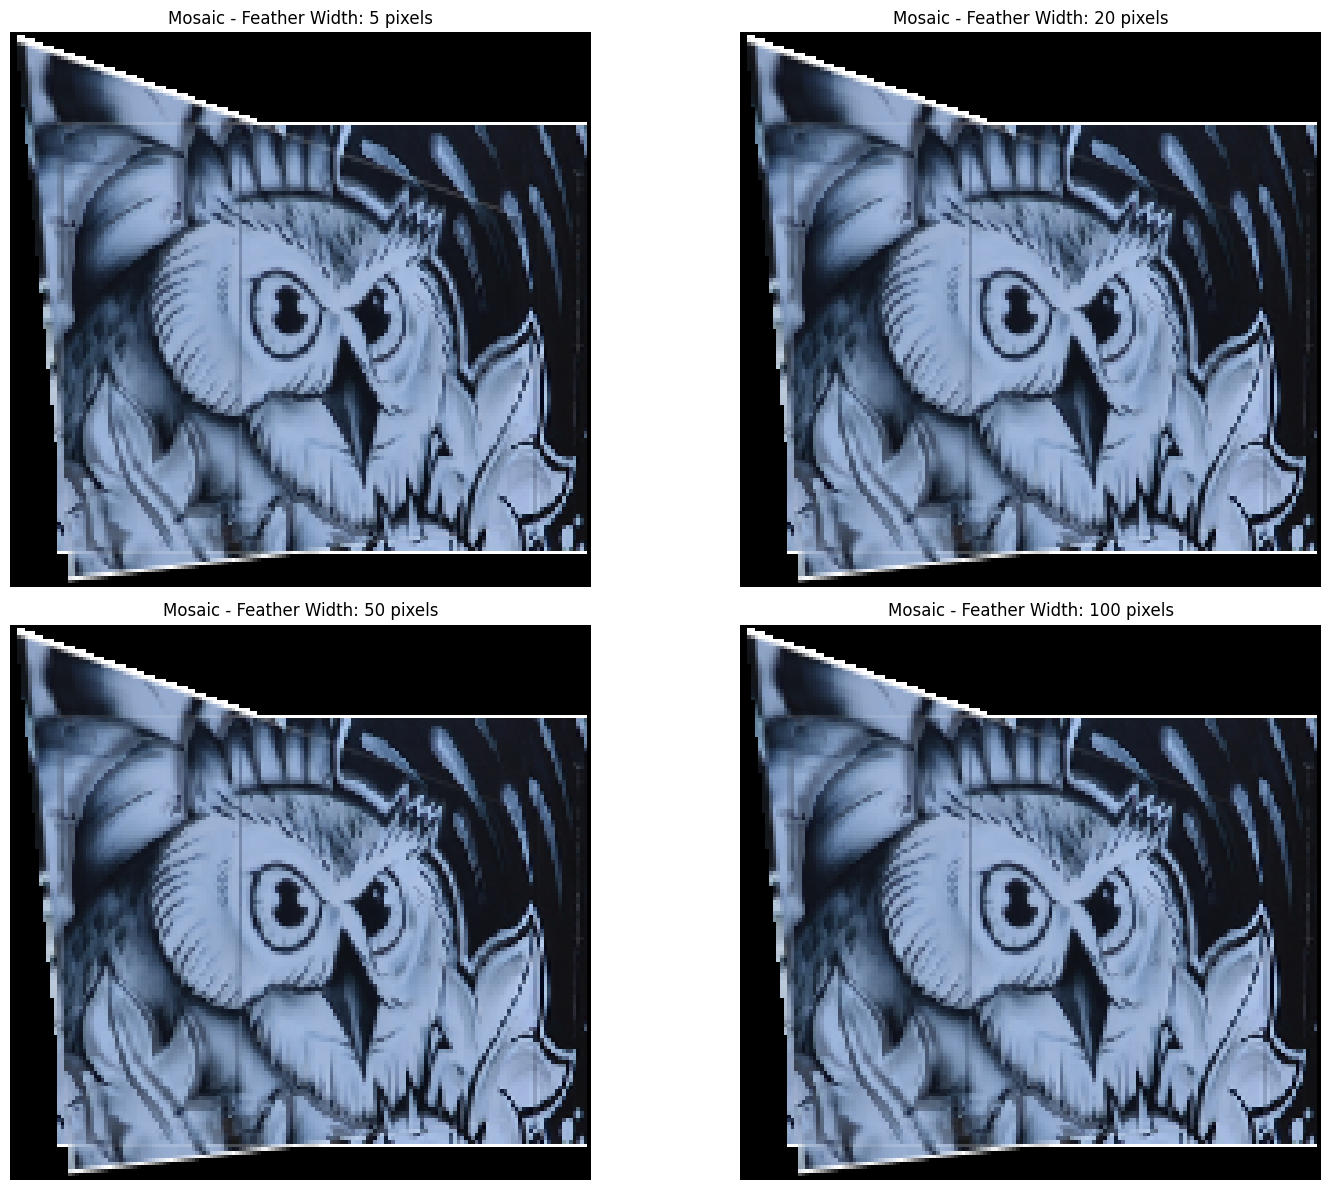

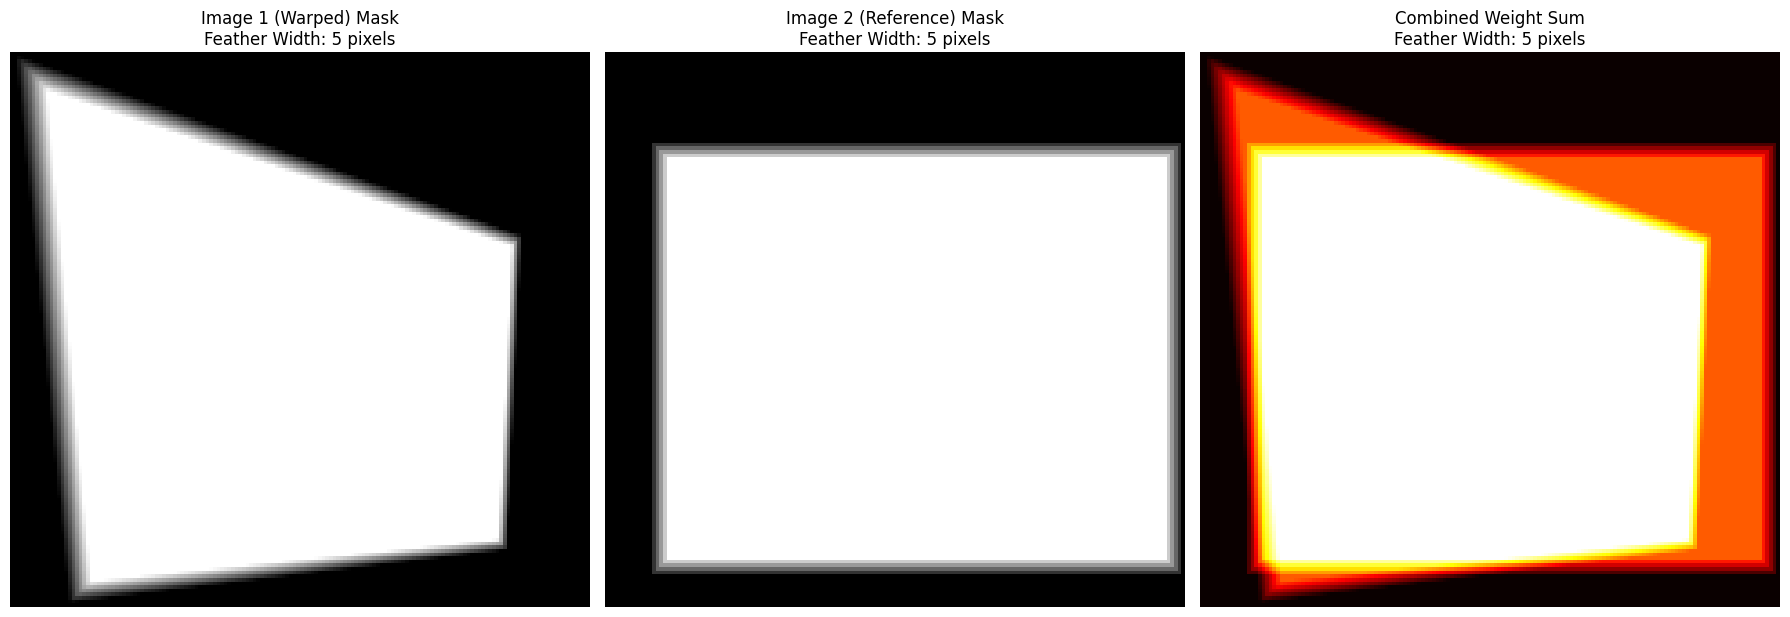

Feather Width 5: Image 1 mask range [0.000, 1.000], Image 2 mask range [0.000, 1.000], Combined range [0.000, 2.000]


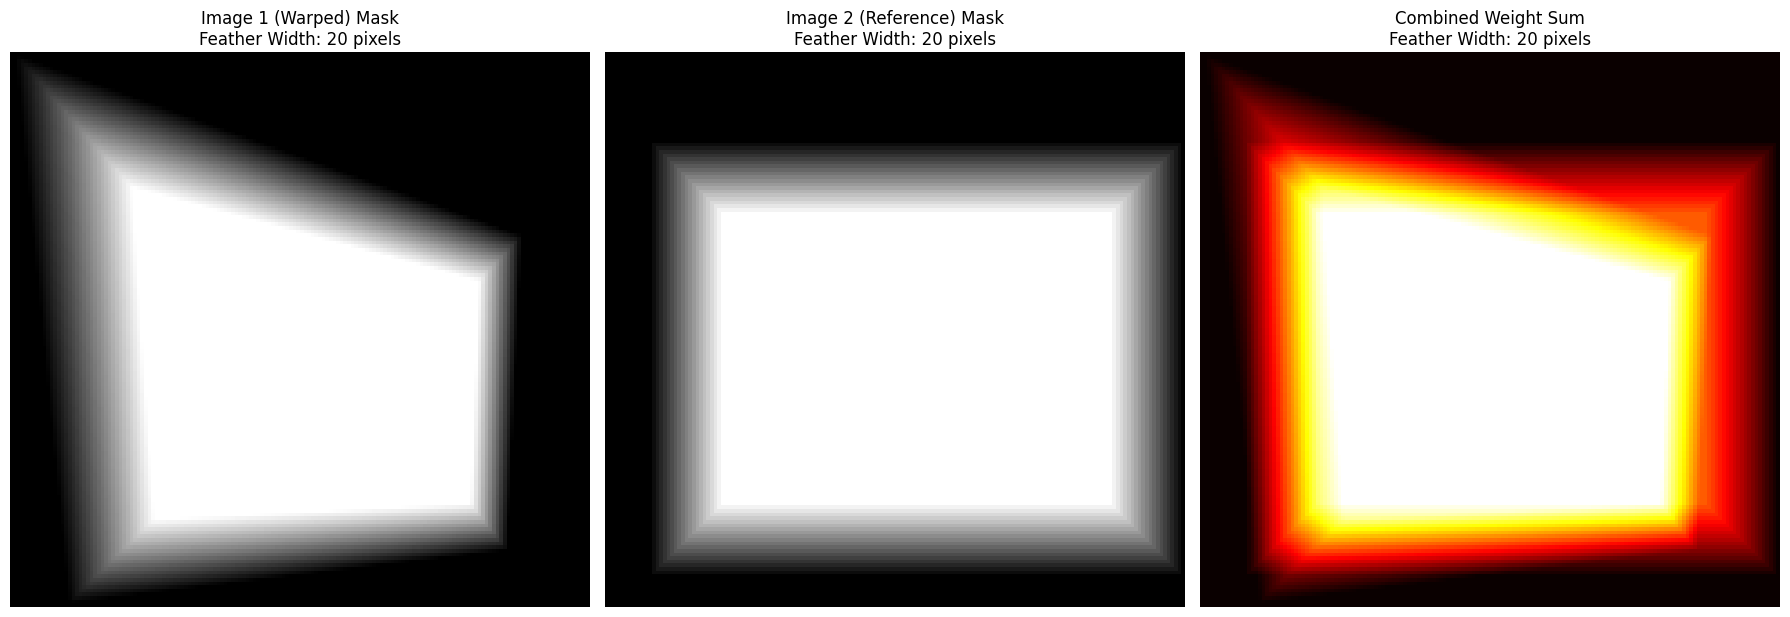

Feather Width 20: Image 1 mask range [0.000, 1.000], Image 2 mask range [0.000, 1.000], Combined range [0.000, 2.000]


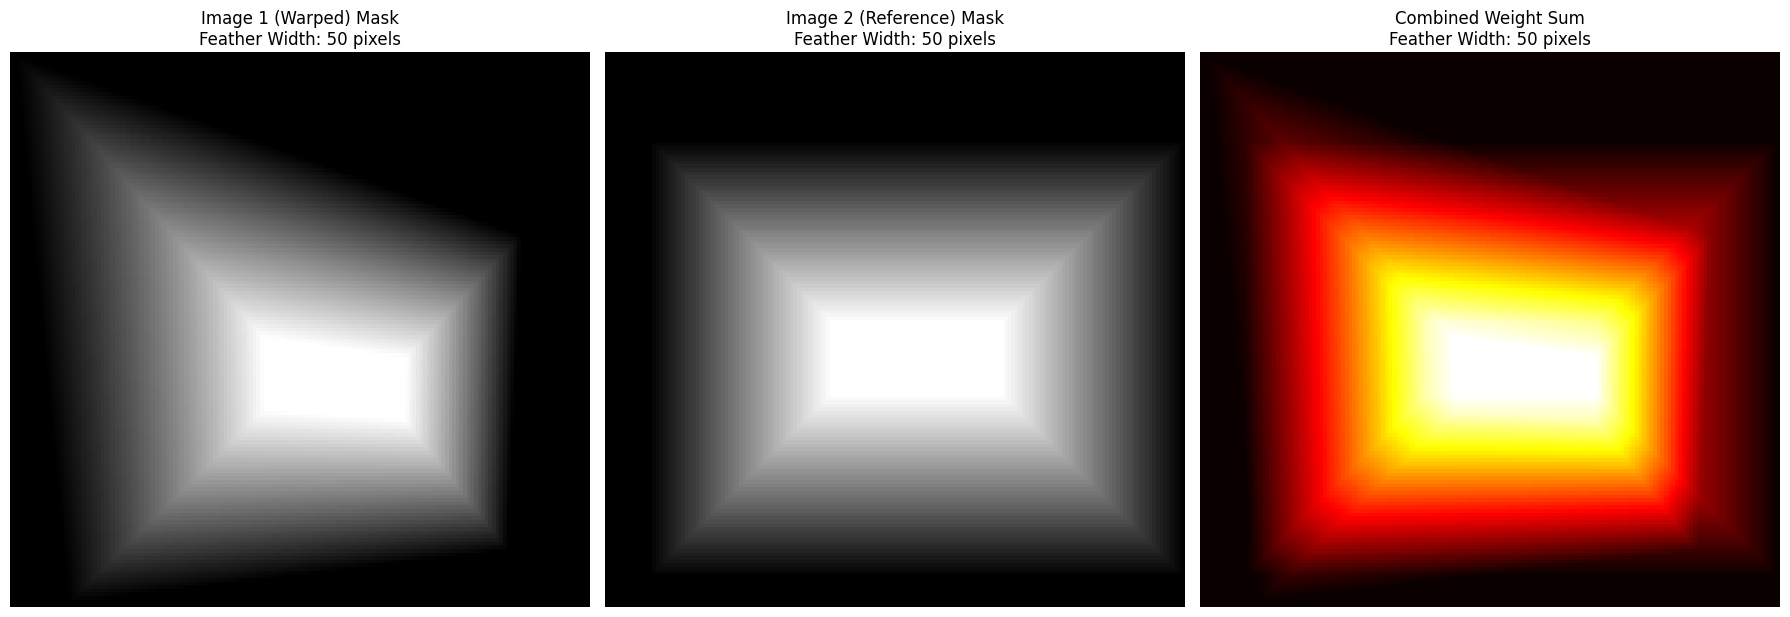

Feather Width 50: Image 1 mask range [0.000, 1.000], Image 2 mask range [0.000, 1.000], Combined range [0.000, 2.000]


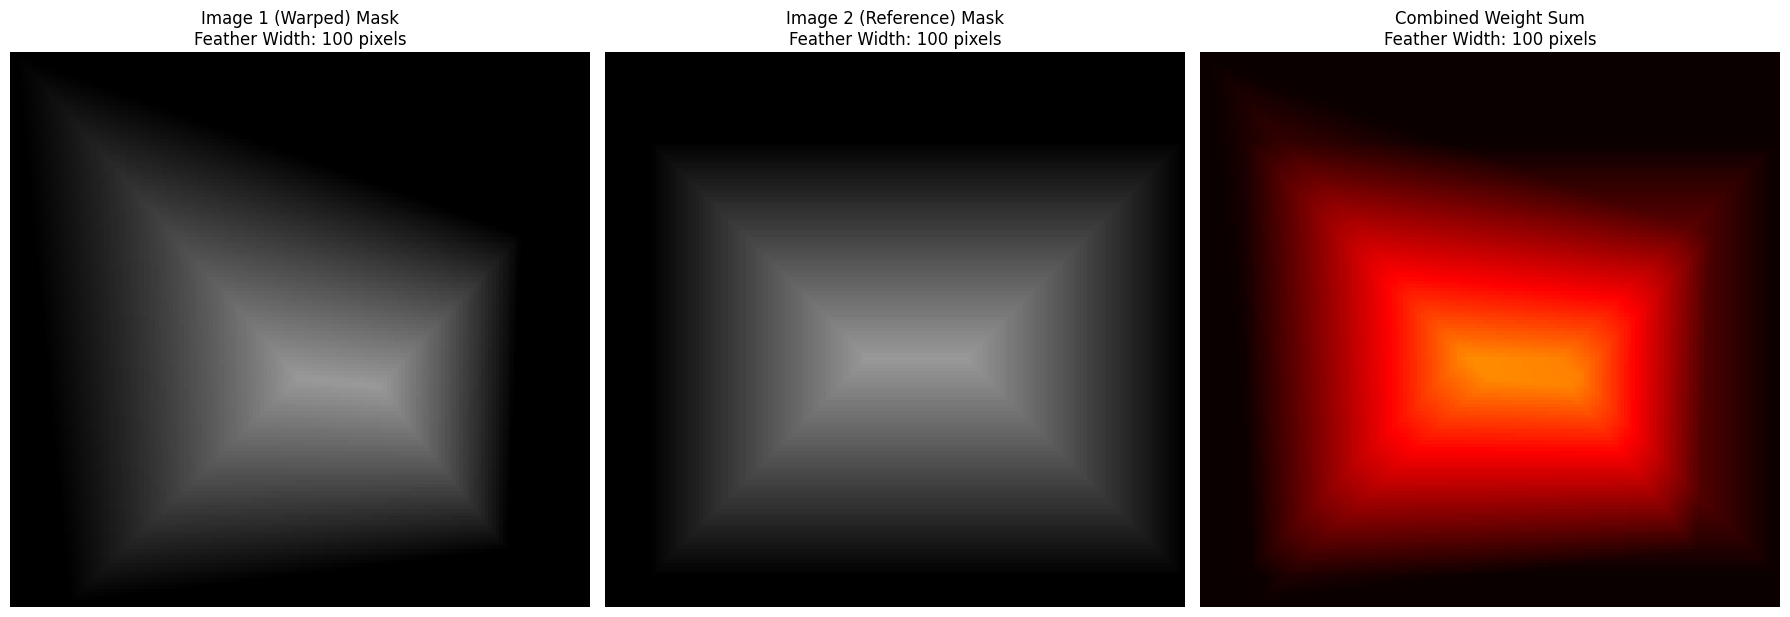

Feather Width 100: Image 1 mask range [0.000, 0.600], Image 2 mask range [0.000, 0.600], Combined range [0.000, 1.150]


In [53]:
# Try different feather widths to see the effect
feather_widths = [5, 20, 50, 100]

# Create mosaics and collect masks
mosaics = []
all_masks = []

for fw in feather_widths:
    # We need to modify create_mosaic to return masks, or compute them separately
    # For now, let's create a helper function to visualize masks
    mosaic_fw = create_mosaic([img1, img2], [H_inv, None], reference_idx=1, feather_width=fw)
    mosaics.append(mosaic_fw)

# Display mosaics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, fw in enumerate(feather_widths):
    axes[idx].imshow(mosaics[idx])
    axes[idx].set_title(f'Mosaic - Feather Width: {fw} pixels', fontsize=12)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Now compute and display the alpha masks
def compute_warped_masks(images, homographies, feather_widths, reference_idx=0):
    """Compute warped alpha masks for visualization."""
    # Normalize images (same as in create_mosaic)
    normalized_images = []
    for img in images:
        if img.shape[2] == 4:
            img = img[:, :, :3]
        if img.max() <= 1.0 + 1e-6:
            img = (img * 255.0).astype(np.float32)
        else:
            img = img.astype(np.float32)
        img = np.clip(img, 0, 255)
        normalized_images.append(img)
    images = normalized_images
    
    # Compute bbox
    forward_homographies = []
    for H in homographies:
        if H is not None:
            forward_homographies.append(np.linalg.inv(H))
        else:
            forward_homographies.append(None)
    
    bbox, offset = compute_mosaic_bbox(images, forward_homographies)
    min_x, min_y, max_x, max_y = bbox
    offset_x, offset_y = offset
    out_w = int(max_x - min_x + 1)
    out_h = int(max_y - min_y + 1)
    
    all_masks = []
    
    for fw in feather_widths:
        masks_for_this_fw = []
        for i, (img, H) in enumerate(zip(images, homographies)):
            h, w = img.shape[:2]
            
            # Create coordinate grid
            y_coords, x_coords = np.mgrid[0:out_h, 0:out_w]
            
            if H is not None:
                x_coords_adj = x_coords - offset_x
                y_coords_adj = y_coords - offset_y
                coords = np.stack([x_coords_adj.flatten(), y_coords_adj.flatten(), np.ones(out_h * out_w)])
                source_coords = (H @ coords).T
                source_coords = source_coords[:, :2] / source_coords[:, 2:3]
                source_x = source_coords[:, 0].reshape(out_h, out_w)
                source_y = source_coords[:, 1].reshape(out_h, out_w)
            else:
                source_x = x_coords - offset_x
                source_y = y_coords - offset_y
            
            # Create alpha mask
            alpha = create_alpha_mask((h, w), fw)
            
            # Warp the alpha mask
            alpha_warped = cv2.remap(alpha,
                                    source_x.astype(np.float32),
                                    source_y.astype(np.float32),
                                    cv2.INTER_LINEAR,
                                    borderMode=cv2.BORDER_CONSTANT)
            
            # Apply valid mask
            valid_mask = (source_x >= 0) & (source_x < w) & (source_y >= 0) & (source_y < h)
            alpha_warped = alpha_warped * valid_mask
            
            masks_for_this_fw.append(alpha_warped)
        
        all_masks.append(masks_for_this_fw)
    
    return all_masks, out_w, out_h

# Compute masks for all feather widths
all_masks, out_w, out_h = compute_warped_masks([img1, img2], [H_inv, None], feather_widths, reference_idx=1)

# Display masks
for fw_idx, fw in enumerate(feather_widths):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Show individual masks
    axes[0].imshow(all_masks[fw_idx][0], cmap='gray', vmin=0, vmax=1)
    axes[0].set_title(f'Image 1 (Warped) Mask\nFeather Width: {fw} pixels', fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(all_masks[fw_idx][1], cmap='gray', vmin=0, vmax=1)
    axes[1].set_title(f'Image 2 (Reference) Mask\nFeather Width: {fw} pixels', fontsize=12)
    axes[1].axis('off')
    
    # Show combined mask (weight sum)
    combined_mask = all_masks[fw_idx][0] + all_masks[fw_idx][1]
    axes[2].imshow(combined_mask, cmap='hot', vmin=0, vmax=2)
    axes[2].set_title(f'Combined Weight Sum\nFeather Width: {fw} pixels', fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Feather Width {fw}: Image 1 mask range [{all_masks[fw_idx][0].min():.3f}, {all_masks[fw_idx][0].max():.3f}], "
          f"Image 2 mask range [{all_masks[fw_idx][1].min():.3f}, {all_masks[fw_idx][1].max():.3f}], "
          f"Combined range [{combined_mask.min():.3f}, {combined_mask.max():.3f}]")


DEBUG: Image 0 before normalization: dtype=float32, min=0.012, max=1.000, mean=0.463
DEBUG: Image 0 normalized (was [0,1]): min=3.000, max=255.000, mean=117.998
DEBUG: Image 1 before normalization: dtype=float32, min=0.000, max=1.000, mean=0.448
DEBUG: Image 1 normalized (was [0,1]): min=0.000, max=255.000, mean=114.278
DEBUG: bbox = (-3, -43, 201, 138)
DEBUG: offset = (3, 43)
DEBUG: output dimensions = 205 x 182
DEBUG: Image 0: 17640 valid pixels out of 37310 total
DEBUG: Image 0: alpha_warped min=0.000, max=1.000, mean=0.204
DEBUG: Image 0: warped min=0.000, max=255.000, mean=55.789
DEBUG: Image 1: 26338 valid pixels out of 37310 total
DEBUG: Image 1: alpha_warped min=0.000, max=1.000, mean=0.283
DEBUG: Image 1: warped min=0.000, max=255.000, mean=74.399
DEBUG: weight_sum min=0.000, max=2.000, mean=0.488
DEBUG: Pixels with zero weight: 10287
DEBUG: Mosaic before uint8 conversion: min=0.00, max=255.00, mean=74.56


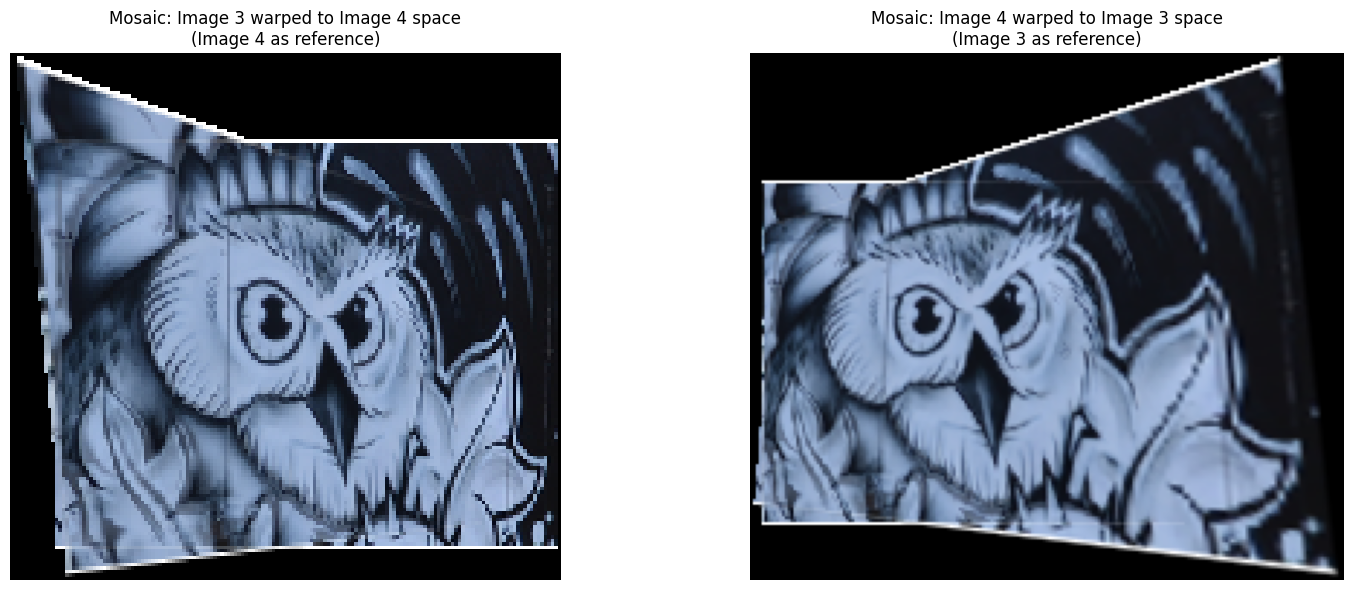

In [48]:
# Alternative approach: Warp both images into a new common projection
# We can create a homography that warps both images to a middle ground
# For simplicity, let's warp image2 to image1's space and image1 stays unwarped

# Warp image2 to image1's space (using H directly)
mosaic_alt = create_mosaic([img1, img2], [None, H], reference_idx=0, feather_width=50)

# Display comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].imshow(mosaic)
axes[0].set_title('Mosaic: Image 3 warped to Image 4 space\n(Image 4 as reference)', fontsize=12)
axes[0].axis('off')

axes[1].imshow(mosaic_alt)
axes[1].set_title('Mosaic: Image 4 warped to Image 3 space\n(Image 3 as reference)', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [56]:
def build_gaussian_pyramid(image, levels):
    """
    Build a Gaussian pyramid by repeatedly downsampling the image.
    
    Parameters:
    -----------
    image : numpy array
        Input image
    levels : int
        Number of pyramid levels
    
    Returns:
    --------
    pyramid : list of numpy arrays
        Gaussian pyramid (from finest to coarsest)
    """
    pyramid = [image.astype(np.float32)]
    
    for i in range(levels - 1):
        # Blur and downsample by factor of 2
        blurred = cv2.GaussianBlur(pyramid[-1], (5, 5), 0)
        # Downsample: take every other pixel
        downsampled = blurred[::2, ::2]
        pyramid.append(downsampled)
    
    return pyramid


In [55]:
def build_laplacian_pyramid(gaussian_pyramid):
    """
    Build a Laplacian pyramid from a Gaussian pyramid.
    The Laplacian pyramid contains the difference between levels.
    
    Parameters:
    -----------
    gaussian_pyramid : list of numpy arrays
        Gaussian pyramid
    
    Returns:
    --------
    laplacian_pyramid : list of numpy arrays
        Laplacian pyramid (from finest to coarsest)
    """
    laplacian_pyramid = []
    
    for i in range(len(gaussian_pyramid) - 1):
        # Get current level
        current = gaussian_pyramid[i]
        # Get next (coarser) level
        next_level = gaussian_pyramid[i + 1]
        
        # Upsample the coarser level to match current level size
        h, w = current.shape[:2]
        upsampled = cv2.resize(next_level, (w, h), interpolation=cv2.INTER_LINEAR)
        
        # Laplacian = current - upsampled
        laplacian = current - upsampled
        laplacian_pyramid.append(laplacian)
    
    # The coarsest level is just the Gaussian (no difference to compute)
    laplacian_pyramid.append(gaussian_pyramid[-1])
    
    return laplacian_pyramid


## 9. Laplacian Pyramid Blending

Use Laplacian pyramid blending for higher-quality mosaics. This technique blends images at multiple scales, resulting in smoother transitions and better preservation of detail.


In [57]:
def reconstruct_from_laplacian_pyramid(laplacian_pyramid):
    """
    Reconstruct an image from a Laplacian pyramid.
    
    Parameters:
    -----------
    laplacian_pyramid : list of numpy arrays
        Laplacian pyramid (from finest to coarsest)
    
    Returns:
    --------
    image : numpy array
        Reconstructed image
    """
    # Start with the coarsest level
    image = laplacian_pyramid[-1]
    
    # Reconstruct from coarsest to finest
    for i in range(len(laplacian_pyramid) - 2, -1, -1):
        # Upsample current image
        h, w = laplacian_pyramid[i].shape[:2]
        image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)
        # Add the Laplacian detail
        image = image + laplacian_pyramid[i]
    
    return image


In [58]:
def create_mosaic_laplacian(images, homographies, reference_idx=0, levels=5):
    """
    Creates a mosaic using Laplacian pyramid blending for smoother transitions.
    
    Parameters:
    -----------
    images : list of numpy arrays
        List of input images (can be RGB or RGBA, values in [0, 1] or [0, 255])
    homographies : list of numpy arrays or None
        List of homography matrices for backward mapping (inverse transforms).
        None means the image is not warped.
    reference_idx : int
        Index of the reference image (unwarped)
    levels : int
        Number of pyramid levels
    
    Returns:
    --------
    mosaic : numpy array
        Final blended mosaic (uint8, values in [0, 255])
    """
    # Normalize images to [0, 255] range and handle RGBA
    normalized_images = []
    for img in images:
        if img.shape[2] == 4:
            img = img[:, :, :3]
        if img.max() <= 1.0 + 1e-6:
            img = (img * 255.0).astype(np.float32)
        else:
            img = img.astype(np.float32)
        img = np.clip(img, 0, 255)
        normalized_images.append(img)
    images = normalized_images
    
    # Compute bbox
    forward_homographies = []
    for H in homographies:
        if H is not None:
            forward_homographies.append(np.linalg.inv(H))
        else:
            forward_homographies.append(None)
    
    bbox, offset = compute_mosaic_bbox(images, forward_homographies)
    min_x, min_y, max_x, max_y = bbox
    offset_x, offset_y = offset
    out_w = int(max_x - min_x + 1)
    out_h = int(max_y - min_y + 1)
    
    # Warp all images to the output space
    warped_images = []
    masks = []
    
    for i, (img, H) in enumerate(zip(images, homographies)):
        h, w = img.shape[:2]
        
        # Create coordinate grid
        y_coords, x_coords = np.mgrid[0:out_h, 0:out_w]
        
        if H is not None:
            x_coords_adj = x_coords - offset_x
            y_coords_adj = y_coords - offset_y
            coords = np.stack([x_coords_adj.flatten(), y_coords_adj.flatten(), np.ones(out_h * out_w)])
            source_coords = (H @ coords).T
            source_coords = source_coords[:, :2] / source_coords[:, 2:3]
            source_x = source_coords[:, 0].reshape(out_h, out_w)
            source_y = source_coords[:, 1].reshape(out_h, out_w)
        else:
            source_x = x_coords - offset_x
            source_y = y_coords - offset_y
        
        # Create valid mask
        valid_mask = (source_x >= 0) & (source_x < w) & (source_y >= 0) & (source_y < h)
        
        # Warp the image
        warped = np.zeros((out_h, out_w, 3), dtype=np.float32)
        for c in range(3):
            warped[:, :, c] = cv2.remap(img[:, :, c],
                                        source_x.astype(np.float32),
                                        source_y.astype(np.float32),
                                        cv2.INTER_LINEAR,
                                        borderMode=cv2.BORDER_CONSTANT)
        
        warped_images.append(warped)
        masks.append(valid_mask.astype(np.float32))
    
    # Create a smooth blending mask (Gaussian blur of the binary mask)
    # This creates a smooth transition region
    blended_masks = []
    for mask in masks:
        # Apply Gaussian blur to create smooth transitions
        blurred_mask = cv2.GaussianBlur(mask, (51, 51), 0)
        # Normalize so masks sum to 1 where they overlap
        blended_masks.append(blurred_mask)
    
    # Normalize masks so they sum to 1
    mask_sum = sum(blended_masks)
    mask_sum = np.maximum(mask_sum, 1e-10)  # Avoid division by zero
    for i in range(len(blended_masks)):
        blended_masks[i] = blended_masks[i] / mask_sum
    
    # Build Laplacian pyramids for each warped image
    laplacian_pyramids = []
    for warped in warped_images:
        # Process each channel separately
        channel_pyramids = []
        for c in range(3):
            gaussian_pyr = build_gaussian_pyramid(warped[:, :, c], levels)
            laplacian_pyr = build_laplacian_pyramid(gaussian_pyr)
            channel_pyramids.append(laplacian_pyr)
        laplacian_pyramids.append(channel_pyramids)
    
    # Build Gaussian pyramid for the mask
    mask_pyramids = []
    for mask in blended_masks:
        gaussian_pyr = build_gaussian_pyramid(mask, levels)
        mask_pyramids.append(gaussian_pyr)
    
    # Blend Laplacian pyramids using the mask pyramids
    blended_laplacian_pyramids = []
    for c in range(3):
        blended_pyr = []
        for level in range(levels):
            blended_level = np.zeros_like(laplacian_pyramids[0][c][level])
            for i in range(len(laplacian_pyramids)):
                # Blend at this level using the corresponding mask level
                mask_level = mask_pyramids[i][level]
                # Handle different sizes (expand mask if needed)
                if mask_level.shape != laplacian_pyramids[i][c][level].shape:
                    h, w = laplacian_pyramids[i][c][level].shape[:2]
                    mask_level = cv2.resize(mask_level, (w, h), interpolation=cv2.INTER_LINEAR)
                blended_level += laplacian_pyramids[i][c][level] * mask_level
            blended_pyr.append(blended_level)
        blended_laplacian_pyramids.append(blended_pyr)
    
    # Reconstruct the final image from the blended Laplacian pyramids
    mosaic_channels = []
    for c in range(3):
        reconstructed = reconstruct_from_laplacian_pyramid(blended_laplacian_pyramids[c])
        mosaic_channels.append(reconstructed)
    
    # Combine channels
    mosaic = np.stack(mosaic_channels, axis=2)
    
    # Clip and convert to uint8
    mosaic = np.clip(mosaic, 0, 255).astype(np.uint8)
    
    return mosaic


Creating mosaic with Laplacian pyramid blending...
Creating mosaic with simple weighted averaging for comparison...
DEBUG: Image 0 before normalization: dtype=float32, min=0.012, max=1.000, mean=0.463
DEBUG: Image 0 normalized (was [0,1]): min=3.000, max=255.000, mean=117.998
DEBUG: Image 1 before normalization: dtype=float32, min=0.000, max=1.000, mean=0.448
DEBUG: Image 1 normalized (was [0,1]): min=0.000, max=255.000, mean=114.278
DEBUG: bbox = (-12, -24, 147, 128)
DEBUG: offset = (12, 24)
DEBUG: output dimensions = 160 x 153
DEBUG: Image 0: 15414 valid pixels out of 24480 total
DEBUG: Image 0: alpha_warped min=0.000, max=1.000, mean=0.257
DEBUG: Image 0: warped min=0.000, max=255.000, mean=74.663
DEBUG: Image 1: 17640 valid pixels out of 24480 total
DEBUG: Image 1: alpha_warped min=0.000, max=1.000, mean=0.311
DEBUG: Image 1: warped min=0.000, max=255.000, mean=82.348
DEBUG: weight_sum min=0.000, max=2.000, mean=0.569
DEBUG: Pixels with zero weight: 5625
DEBUG: Mosaic before uint8 

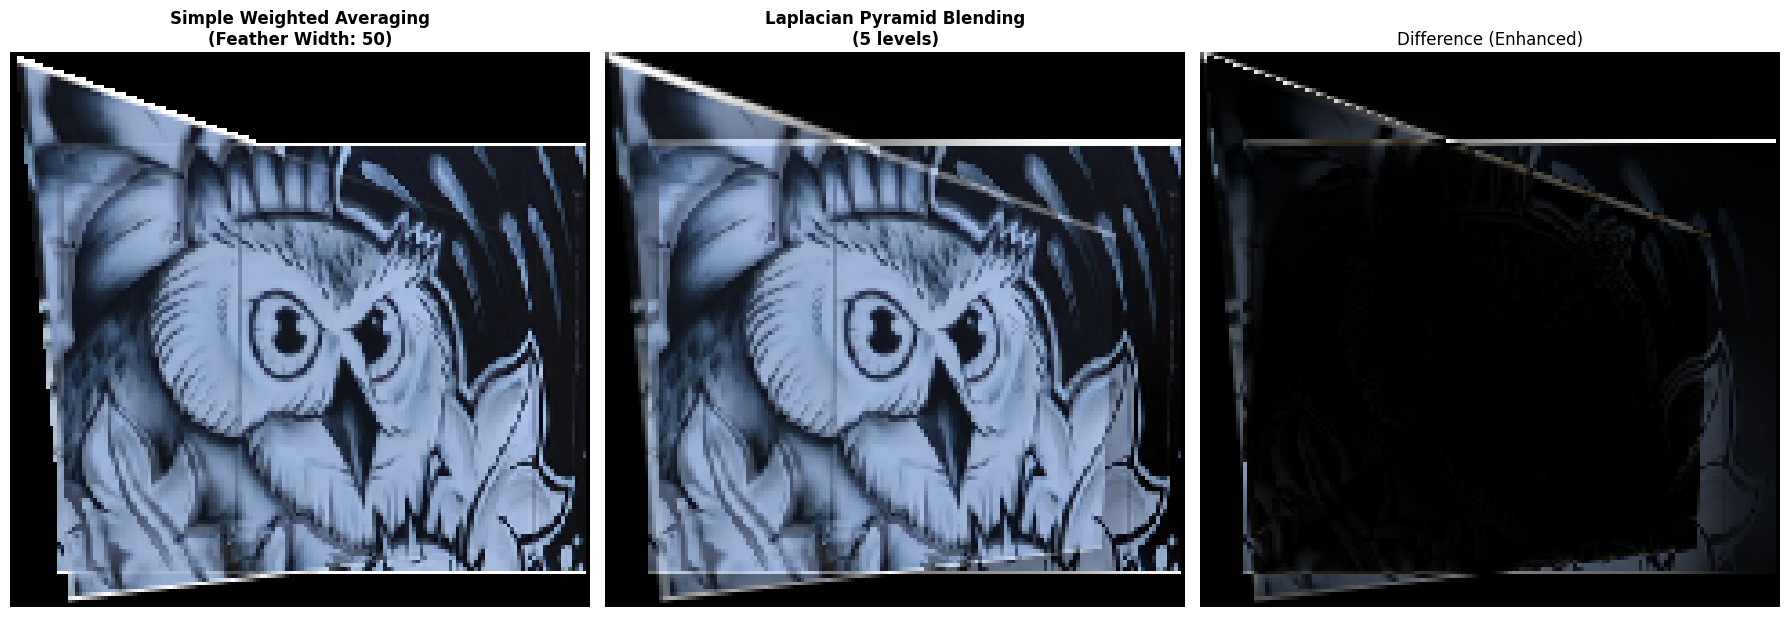


Simple mosaic shape: (153, 160, 3)
Laplacian mosaic shape: (153, 160, 3)
Difference range: [0.00, 254.00]
Mean difference: 8.05


In [59]:
# Create mosaic using Laplacian pyramid blending
print("Creating mosaic with Laplacian pyramid blending...")
mosaic_laplacian = create_mosaic_laplacian([img1, img2], [H_inv, None], reference_idx=1, levels=5)

# Compare with simple blending
print("Creating mosaic with simple weighted averaging for comparison...")
mosaic_simple = create_mosaic([img1, img2], [H_inv, None], reference_idx=1, feather_width=50)

# Display comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(mosaic_simple)
axes[0].set_title('Simple Weighted Averaging\n(Feather Width: 50)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(mosaic_laplacian)
axes[1].set_title('Laplacian Pyramid Blending\n(5 levels)', fontsize=12, fontweight='bold')
axes[1].axis('off')

# Show difference (enhanced for visibility)
diff = np.abs(mosaic_laplacian.astype(float) - mosaic_simple.astype(float))
diff_normalized = (diff / diff.max() * 255).astype(np.uint8) if diff.max() > 0 else diff.astype(np.uint8)
axes[2].imshow(diff_normalized)
axes[2].set_title('Difference (Enhanced)', fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"\nSimple mosaic shape: {mosaic_simple.shape}")
print(f"Laplacian mosaic shape: {mosaic_laplacian.shape}")
print(f"Difference range: [{diff.min():.2f}, {diff.max():.2f}]")
print(f"Mean difference: {diff.mean():.2f}")


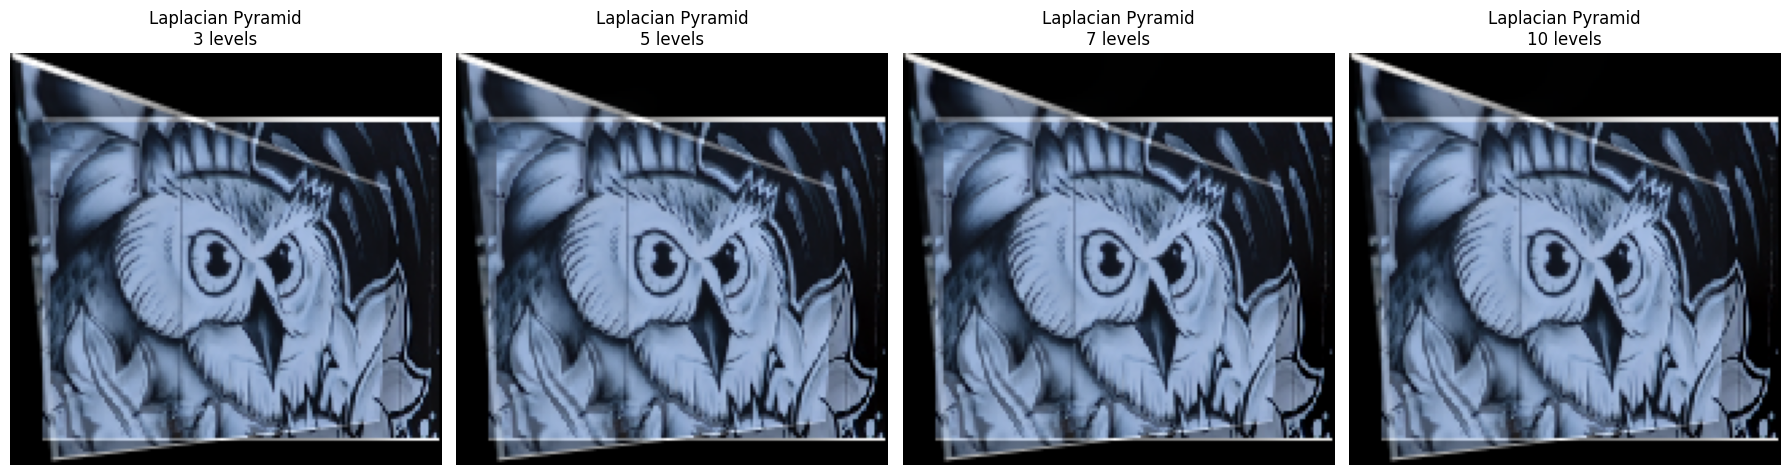

In [63]:
# Try different pyramid levels to see the effect
pyramid_levels = [3, 5, 7, 10]

fig, axes = plt.subplots(1, len(pyramid_levels), figsize=(18, 6))

for idx, levels in enumerate(pyramid_levels):
    mosaic_lp = create_mosaic_laplacian([img1, img2], [H_inv, None], reference_idx=1, levels=levels)
    axes[idx].imshow(mosaic_lp)
    axes[idx].set_title(f'Laplacian Pyramid\n{levels} levels', fontsize=12)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()
